In [28]:
import numpy as np


# 软阈值算子
def soft_thresholding_operator(x, lambda_):
    """
    实现软阈值算子
    :param x: 输入向量或标量
    :param lambda_: 阈值参数
    :return: 软阈值处理后的结果
    """
    return np.sign(x) * np.maximum(0, np.abs(x) - lambda_)


# KKT停机准则
def check_kkt(x, A, b, lambda_):
    """验证Lasso问题的解是否满足KKT条件"""
    y = x + A.T @ (b - A @ x)
    return np.linalg.norm(soft_thresholding_operator(y, lambda_) - x, ord=2) / (1 + np.linalg.norm(x, ord=2))


# 近端梯度下降法求解Lasso回归问题

In [29]:
def pg_lasso(A, b, lambda_, max_iter=10000, tol=1e-5):
    """
    使用近端梯度下降法求解Lasso回归问题
    :param A: 特征矩阵
    :param b: 目标向量
    :param lambda_: L1正则化参数
    :param max_iter: 最大迭代次数
    :param tol: 收敛容限
    :return: 求解得到的权重向量x
    """
    # 初始化beta为零向量
    x = np.zeros(A.shape[1])

    # 计算梯度的Lipschitz常数
    L = np.linalg.norm(A, ord=2) ** 2

    res = []
    # 迭代更新参数x
    for _ in range(max_iter):
        # 计算梯度
        gradient = A.T @ (A @ x - b)

        # 近端梯度更新
        x_new = soft_thresholding_operator(x - gradient / L, lambda_ / L)

        # 检查收敛性
        res.append(check_kkt(x_new, A, b, lambda_))
        if res[-1] <= tol:
            return x_new, res

        x = x_new

    return x, res

# 加速近端梯度下降法求解Lasso回归问题

In [30]:
def apg_lasso(A, b, lambda_, max_iter=10000, tol=1e-5):
    """
    使用加速近端梯度下降法（APG/FISTA）求解Lasso回归问题
    :param A: 特征矩阵
    :param b: 目标向量
    :param lambda_: L1正则化参数
    :param max_iter: 最大迭代次数
    :param tol: 收敛容限
    :return: 求解得到的权重向量x
    """
    m, n = A.shape
    # 初始化
    x = np.zeros(n)
    v = np.zeros(n)
    # 计算梯度的Lipschitz常数
    L = np.linalg.norm(A, ord=2) ** 2
    t = 1
    res = []
    for i in range(max_iter):
        # 近端梯度更新
        gradient = A.T @ (A @ x - b)
        x_new = soft_thresholding_operator(v - gradient / L, lambda_ / L)

        # 更新动量
        t_new = (1 + np.sqrt(1 + 4 * t ** 2)) / 2
        v = x_new + (t - 1) * (x_new - x) / t_new
        t = t_new

        res.append(check_kkt(x_new, A, b, lambda_))
        if res[-1] <= tol:
            return x_new, res
        x = x_new
    return x, res

# ADMM算法求解Lasso回归问题

In [31]:
def admm_lasso(A, b, lambda_, rho, max_iter=1000, tol=1e-5):
    """
    使用ADMM算法求解Lasso回归问题
    :param A: 特征矩阵
    :param b: 目标向量
    :param lambda_: L1正则化参数
    :param rho:
    :param max_iter: 最大迭代次数
    :param tol: 收敛容限
    :return: 求解得到的权重向量x
    """
    m, n = A.shape
    x = np.zeros(n)
    z = np.zeros(n)
    u = np.zeros(n)  # Lagrange multiplier
    res = []
    for _ in range(max_iter):
        x = np.linalg.solve(A.T @ A + rho * np.eye(n), A.T @ b + rho * z - u)
        z = soft_thresholding_operator(x + u / rho, lambda_ / rho)
        u += x - z
        res.append(check_kkt(x, A, b, lambda_))
        if res[-1] <= tol:
            return x, res

    return x, res


# 数值模拟

In [40]:
# 数据生成
# np.random.seed(0)
n_samples, n_features = 10, 1000
matrixA = np.random.randn(n_samples, n_features)
true_coef = 3 * np.random.randn(n_features)
# # 将系数向量中的大部分元素设置为零，以模拟稀疏性
# true_coef[abs(true_coef) < 1] = 0
vectorb = np.dot(matrixA, true_coef) + np.random.normal(size=n_samples)

PG res: 0.006741154232849468
PG: 100000
PG time: 4.606017827987671
APG res: 9.67867512785009e-06
APG: 39848
APG time: 2.118234872817993
ADMM res: 9.988807747623266e-06
ADMM: 4881
ADMM time: 167.03486347198486


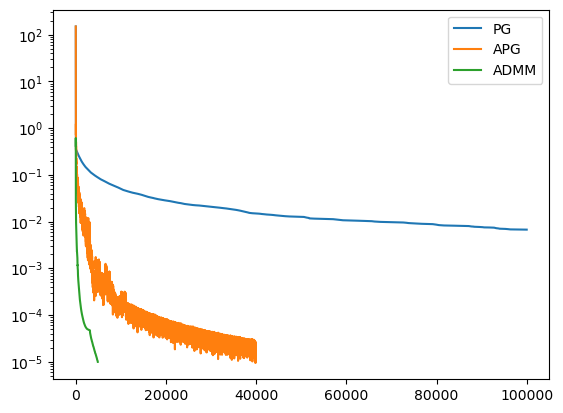

In [41]:
from matplotlib import pyplot as plt
import time

time_1 = time.time()
x, res = pg_lasso(matrixA, vectorb, 0.4, max_iter=100000)
time_2 = time.time()
print('PG res:', res[-1])
print('PG:', len(res))
print('PG time:', time_2 - time_1)
plt.semilogy(res, label='PG')

time_1 = time.time()
x, res = apg_lasso(matrixA, vectorb, 0.4, max_iter=100000)
time_2 = time.time()
print('APG res:', res[-1])
print('APG:', len(res))
print('APG time:', time_2 - time_1)
plt.semilogy(res, label='APG')

time_1 = time.time()
x, res = admm_lasso(matrixA, vectorb, 0.4, 1, max_iter=100000)
time_2 = time.time()
print('ADMM res:', res[-1])
print('ADMM:', len(res))
print('ADMM time:', time_2 - time_1)
plt.semilogy(res, label='ADMM')

plt.legend()
plt.show()